In [1]:
# Konfiguracja startowa
import pickle

DO_TRAIN = False  # czy trenowanie ma być wykonane na nowo, czy wczytane z dysku (jak z dysku to też zbiór testowy jest z dysku, augmentacja itd.)

def load_cache(fn):
    with open(fn, 'rb') as cf:
        return pickle.load(cf)


def write_cache(fn, data):
    with open(fn, 'wb') as cf:
        pickle.dump(data, cf)

In [2]:
# Załadowanie hitów w PNG z katalogu hit-images-final2
# z podziałem na "dot", "track" i "worm" (podkatalogi)

from align_images_pca import align_image
from PIL import Image
import numpy as np
import glob


CACHE_IMAGES = 'cache/images_v2.pickle'

ALL_SRC = 'wybrane_final'


def load_image(image_path, align=True):
    img = Image.open(image_path)
    img = img.convert('L')
    image = np.asarray(img)
    #image = np.asarray(Image.open(image_path).convert('L'))
    if align:
        image = align_image(image)
    mask = np.where(image > 25, 1, 0)
    image = mask * image
    if np.max(image) == 0:
        return None
    image = image.astype(np.float32) / np.max(image)
    image = np.expand_dims(image, 2)
    return image


def load_images(src):
    images = []
    files_used = []
    files = list(glob.glob("%s/*.png" % src))
    files = sorted(files)
    for image_path in files:
        image = load_image(src)
        if image is None:
            continue
        images.append(image)
        files_used.append(image_path)
    return np.asarray(images), files_used


if DO_TRAIN:
    all_set, all_files = load_images(ALL_SRC)
    write_cache(CACHE_IMAGES, [all_set, all_files])
else:
    [all_set, all_files] = load_cache(CACHE_IMAGES)

print('len(all_set): %d' % all_set.shape[0])

len(all_set): 13824


In [3]:
# augmentacja przez mirror, czyli pomnożenie próbek 2x przez dodanie lustrzanie odbitych

import pickle
CACHE_AUGMENTATION = 'cache/augmentation_v2.pickle'

def augmentation_mirror(src, files):
    images = []
    files_aug = []
    for i in range(0, len(src)):
        img = src[i]
        images.append(img)
        images.append(np.flip(img))
        files_aug.append(files[i])
        files_aug.append(files[i])
    return np.asarray(images), files_aug

if DO_TRAIN:
    all2_set, all2_files = augmentation_mirror(all_set, all_files)
    write_cache(CACHE_AUGMENTATION, [all2_set, all2_files])
else:
    [all2_set, all2_files] = load_cache(CACHE_AUGMENTATION)

print('len(dots2_set): %d' % all2_set.shape[0])

len(dots2_set): 27648


In [4]:
# wygenerowanie zbioru train, validate i test o proporcjach odpowiednio 60%, 20% i 20%
# zwracane listy zawierają indeksy próbek, które zostały przydzielone do ww. ziorów

import pickle
CACHE_DIV = 'cache/sets_tvt.pickle'

def train_validate_test_split(df, train_percent=.8, seed=None):
    p = np.random.permutation(df.shape[0])
    n = int(train_percent * len(p))
    train = p[:n]
    validation = p[n:]
    return train, validation

if DO_TRAIN:
    all2_train, all2_validate = train_validate_test_split(all2_set)
    write_cache(CACHE_DIV, [all2_train, all2_validate])
else:
    [all2_train, all2_validate] = load_cache(CACHE_DIV)

print('len(all2_set): %d/%d' % (all2_train.shape[0], all2_validate.shape[0]))

len(all2_set): 22118/5530


In [5]:
# wytrenowanie kanałów
# * tracks
# * tnd (tracks and dots)

from commons import *
from dataset_loader import load_from_file
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

#DOTS_DST = 'cache/dots_100000.pickle'
#ARTIFACTS_DST = 'cache/artifacts_100000.pickle'

#DOTS_AC = 'cache/dots_100000.h5'
#TRACKS_AC = 'cache/th_dots_optics_100000.h5'
#WORMS_AC = 'cache/worms_100000.h5'
#ARTIFACTS_AC = 'cache/artifacts_100000.h5'
ALL_AC = 'cache/th_all_%d.h5'

def train_and_test(train_set, validation_set, fn_template, latentDim=16):
    fn = fn_template % latentDim
    autoencoder = original_autoencoder(latentDim=latentDim)
    autoencoder = train_or_cache(train_set, autoencoder, fn, validation_set=validation_set, force_train=True, latentDim=latentDim)

    for df_func, df_name in zip(
            [dm_func_mean],
            ['mean']
    ):
        for img_set, set_names in zip([validation_set], ['train']):
            decoded = autoencoder.predict(img_set)

            vis, errors = visualize_predictions(decoded, img_set, df_func, False, 16)
            img_path = fn.replace('.h5', '-vis.png')
            hist_path = fn.replace('.h5', '-hist.png')
            cv2.imwrite(img_path, vis)
            display(Image.open(img_path))
            if len(img_set) > 256:
                vis, errors = visualize_predictions(decoded, img_set, df_func, False)
                img_path = fn.replace('.h5', '-vis_full.png')
                cv2.imwrite(img_path, vis)

            plt.figure(figsize=(8,6))
            plt.hist(errors, bins=100, alpha=0.5, label=set_names)
            plt.xlabel("Data", size=14)
            plt.ylabel("Count", size=14)
            plt.title(df_name)
            plt.legend(loc='upper right')
            plt.savefig(hist_path)

if DO_TRAIN:
    for latentD in [16]:
        train_and_test(all2_set[all2_train], all2_set[all2_validate], ALL_AC, latentD)

In [6]:
if DO_TRAIN:
    for latentD in [2, 4, 6, 8, 12, 24, 32, 48, 64]:
        train_and_test(all2_set[all2_train], all2_set[all2_validate], ALL_AC, latentD)

In [7]:
# zapis embeddingu do pliku

from keras.models import load_model

def encoder_embedding(model_file, test_set):
    encoder = load_model(model_file.replace('.h5', '-encoder.h5'))
    embedding = encoder.predict(test_set)
    #with_c = np.vstack([v, np.ones(v.shape) * c])
    #transposed = with_c.transpose()
    return embedding

#all_embedding = encoder_embedding(ALL_AC % 64, all_set)
#all_embedding_files = np.hstack(all_files)


# np.save("res/emb_array_all_%d" % 16, all_embedding)

# with open("res/file_list_all.txt", 'w') as fp:
#     for ff in all_embedding_files:
#         fp.write(ff + "\n")


In [8]:
zero_to_one = (np.asarray(range(10)) + 1) / 10.0
one_to_ten = np.asarray(range(9)) + 2
ten_to_hundreds = (np.asarray(range(39)) + 2) * 10

eps_used = list((np.hstack([zero_to_one, one_to_ten, ten_to_hundreds])))
print(eps_used)

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0]


In [9]:
def find_sigma(func, embedding, t_files, latentDim, min_samples=5, start_eps=200, percent=0.2):
    size = float(embedding.shape[0])
    left_eps = 0.1
    right_eps = 1000.0
    looking_count = round(size * (percent / 100.0))
    while True:
        eps = (left_eps + right_eps) / 2.0
        p = func(embedding, t_files, latentDim, eps, False, min_samples)
        if p == looking_count:
            break

        if p > looking_count:
            left_eps = eps
        else:
            right_eps = eps
    print('Znalezione: latentDim=%d, min_samples=%d, eps=%f' % (latentDim, min_samples, eps))
    func(embedding, t_files, latentDim, eps, True, min_samples)
    return eps


looking_ld = [2, 4, 6, 8, 12, 16, 24, 32, 48, 64]
looking_ms = [3, 4, 5, 6, 7, 8]

All files: 13824
wybrane_final\24629792.png
wybrane_final\8471762.png
wybrane_final\18408050.png
wybrane_final\1355336.png
wybrane_final\17848337.png
wybrane_final\11071122.png
wybrane_final\21978788.png
wybrane_final\19688386.png
wybrane_final\18048656.png
wybrane_final\11897290.png
wybrane_final\1306300.png
wybrane_final\1350798.png
wybrane_final\21974209.png
wybrane_final\21972358.png
wybrane_final\24308377.png
wybrane_final\1767172.png
wybrane_final\24597739.png
wybrane_final\23190794.png
wybrane_final\6622167.png
wybrane_final\7644472.png
wybrane_final\23213722.png
wybrane_final\21598536.png
wybrane_final\7059791.png
wybrane_final\1892280.png
wybrane_final\10679843.png
wybrane_final\18680229.png
wybrane_final\24209079.png
wybrane_final\11809493.png


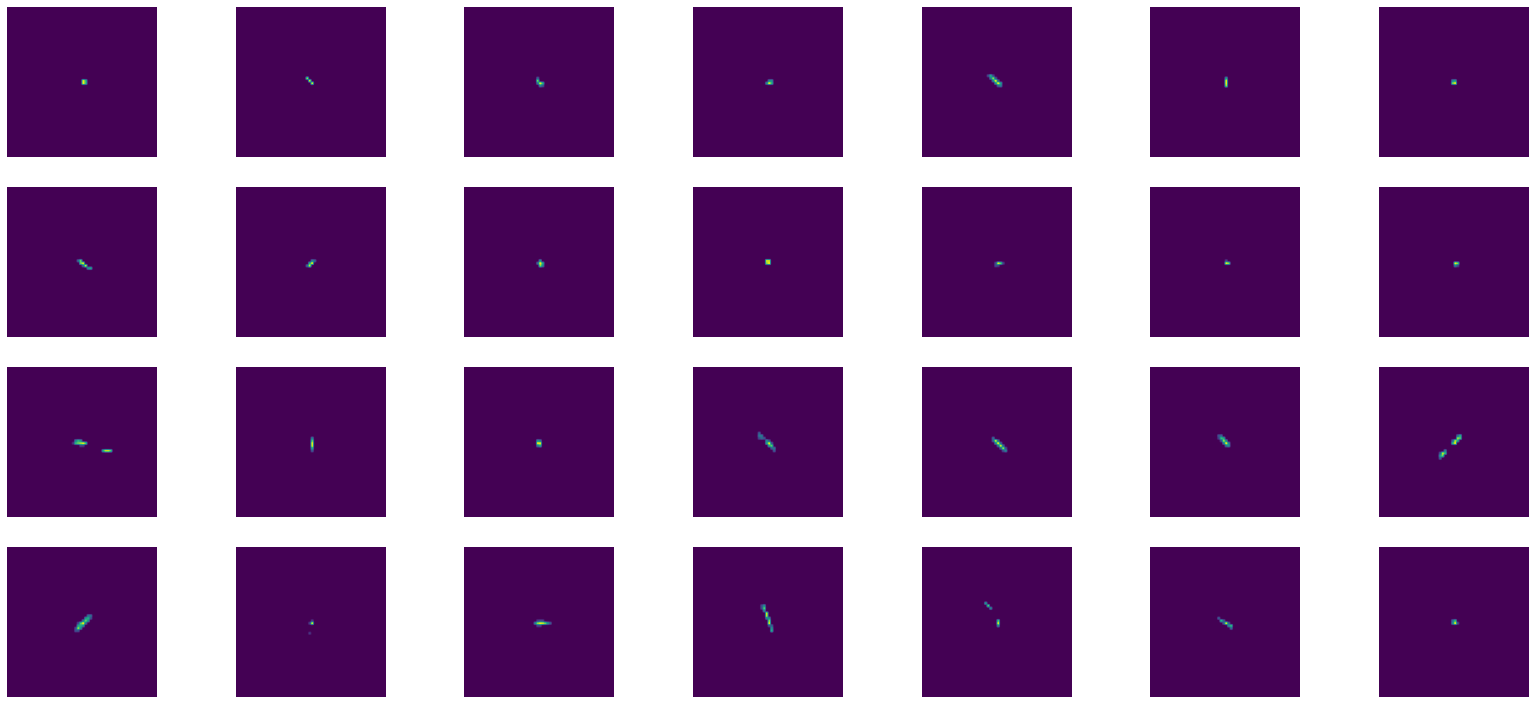

All files: 13824
wybrane_final\24601712.png
wybrane_final\13867115.png
wybrane_final\6697624.png
wybrane_final\22436664.png
wybrane_final\24602427.png
wybrane_final\11813494.png
wybrane_final\11898088.png
wybrane_final\22028192.png
wybrane_final\21972044.png
wybrane_final\5213244.png
wybrane_final\6840984.png
wybrane_final\10844020.png
wybrane_final\24590965.png
wybrane_final\24594040.png
wybrane_final\1064676.png
wybrane_final\16626396.png
wybrane_final\13696770.png
wybrane_final\11681641.png
wybrane_final\24602533.png
wybrane_final\21983465.png
wybrane_final\24597976.png
wybrane_final\1576882.png
wybrane_final\22699077.png
wybrane_final\24602050.png
wybrane_final\24594078.png
wybrane_final\13842508.png
wybrane_final\11670631.png
wybrane_final\11899877.png


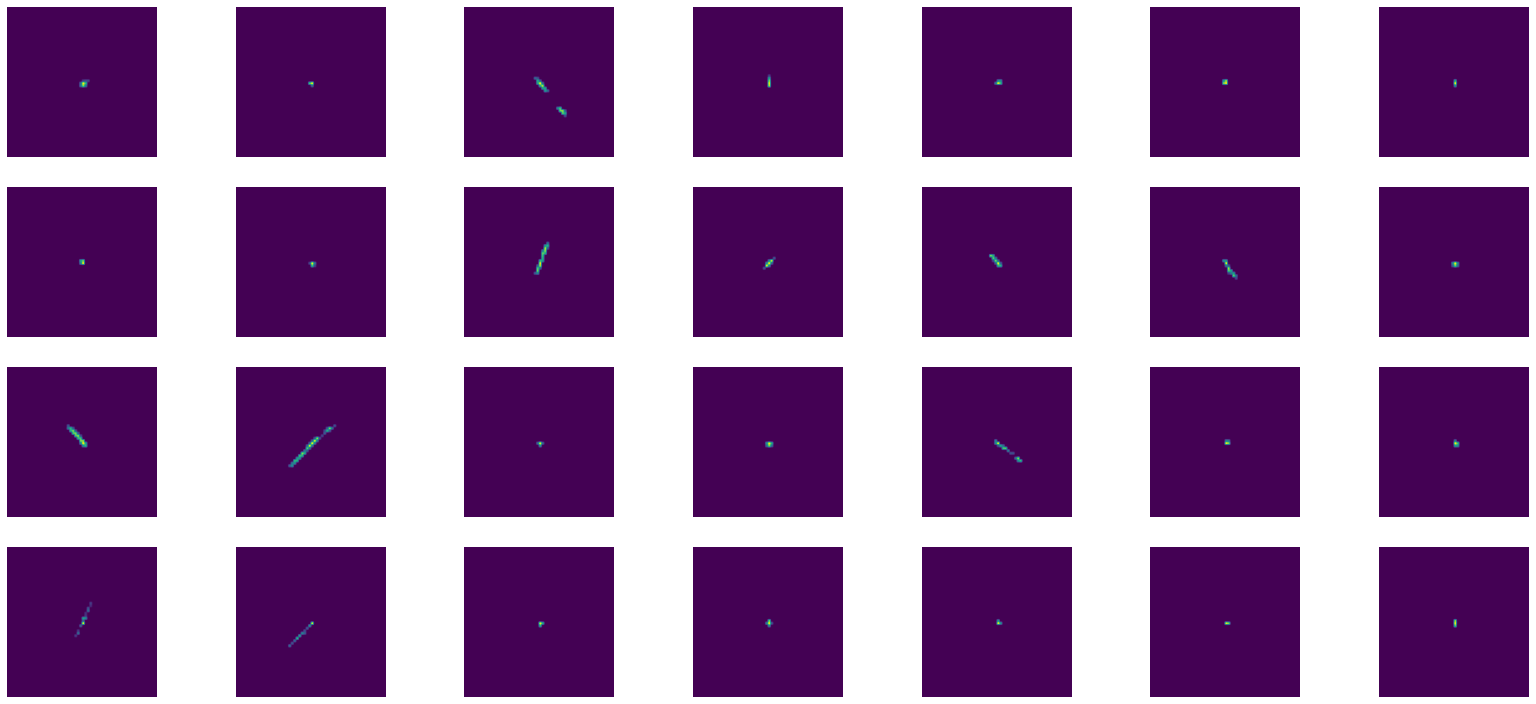

All files: 13824
wybrane_final\22028109.png
wybrane_final\24624220.png
wybrane_final\11826378.png
wybrane_final\22354337.png
wybrane_final\21979396.png
wybrane_final\24598003.png
wybrane_final\17335792.png
wybrane_final\17203122.png
wybrane_final\21972239.png
wybrane_final\24603177.png
wybrane_final\1383847.png
wybrane_final\23763958.png
wybrane_final\17459739.png
wybrane_final\13818477.png
wybrane_final\24589915.png
wybrane_final\1310766.png
wybrane_final\4063311.png
wybrane_final\4808707.png
wybrane_final\6687089.png
wybrane_final\13610833.png
wybrane_final\13842974.png
wybrane_final\22391035.png
wybrane_final\17875600.png
wybrane_final\11683037.png
wybrane_final\11431511.png
wybrane_final\24589118.png
wybrane_final\4604933.png
wybrane_final\1311142.png


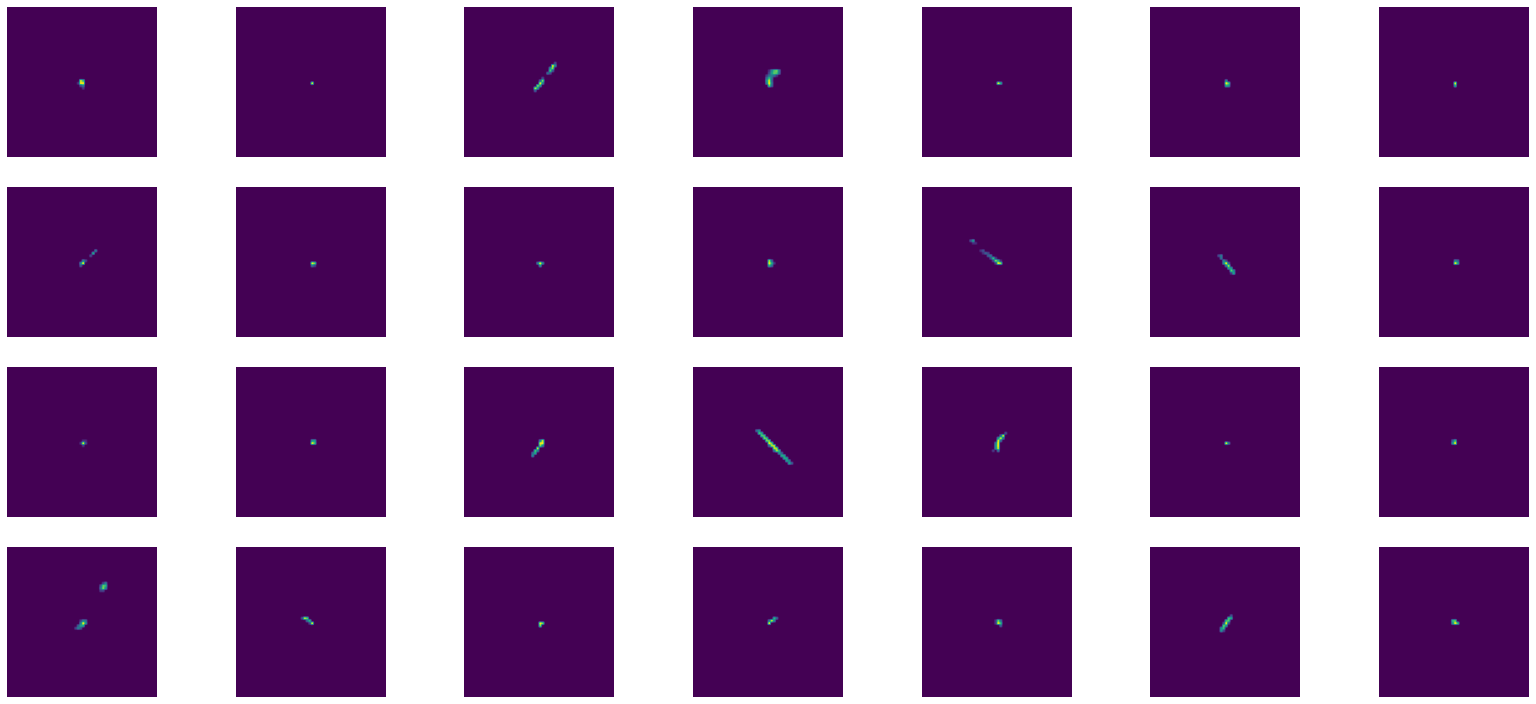

All files: 13824
wybrane_final\23193612.png
wybrane_final\11683279.png
wybrane_final\22934717.png
wybrane_final\24401333.png
wybrane_final\1366566.png
wybrane_final\22324069.png
wybrane_final\10468029.png
wybrane_final\11681975.png
wybrane_final\6019933.png
wybrane_final\22436874.png
wybrane_final\15819268.png
wybrane_final\24185923.png
wybrane_final\1372413.png
wybrane_final\13610542.png
wybrane_final\17214596.png
wybrane_final\1339315.png
wybrane_final\23518031.png
wybrane_final\24177527.png
wybrane_final\22110706.png
wybrane_final\23517947.png
wybrane_final\7278284.png
wybrane_final\1326026.png
wybrane_final\21974258.png
wybrane_final\8440868.png
wybrane_final\22939012.png
wybrane_final\7075723.png
wybrane_final\11896522.png
wybrane_final\23051370.png


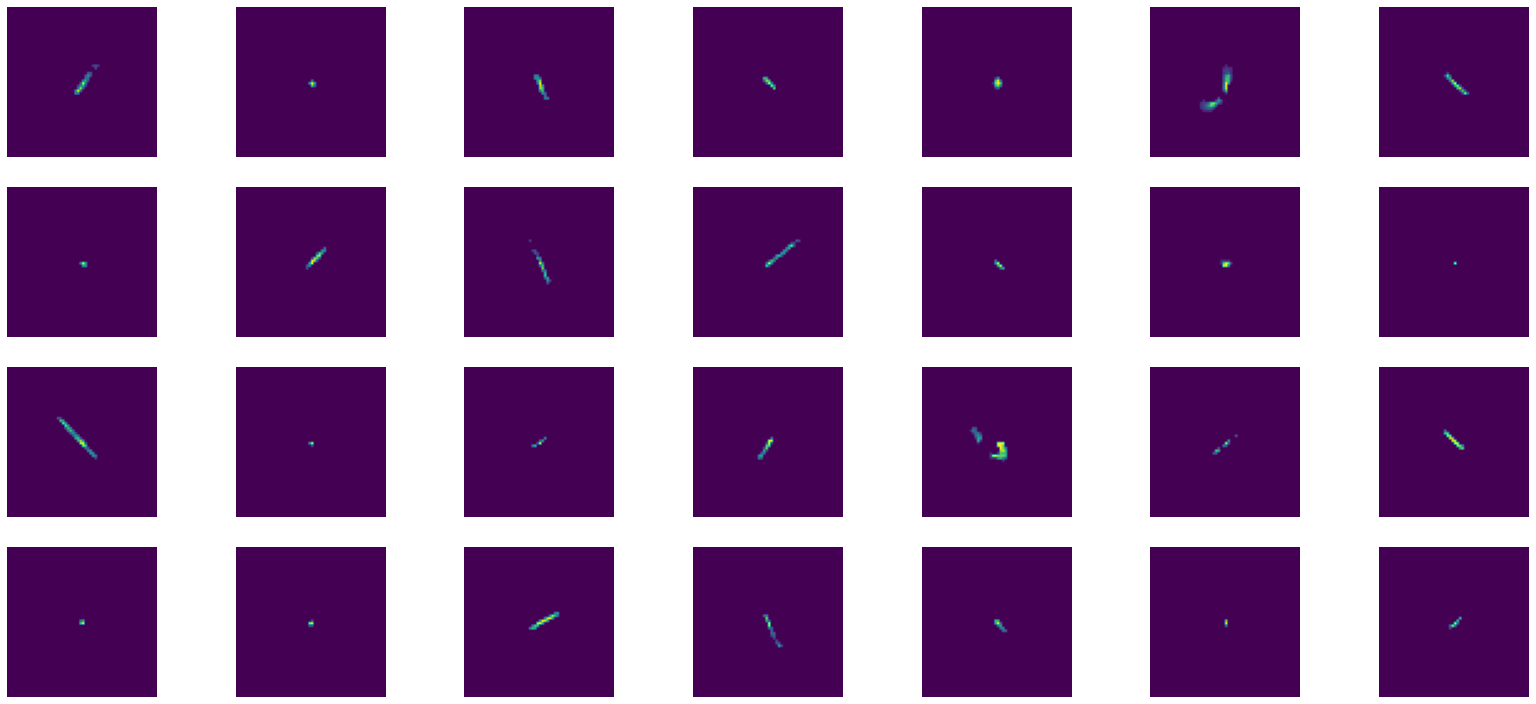

All files: 13824
wybrane_final\11817532.png
wybrane_final\21977675.png
wybrane_final\23092049.png
wybrane_final\24601605.png
wybrane_final\22667187.png
wybrane_final\22356004.png
wybrane_final\24591104.png
wybrane_final\24602854.png
wybrane_final\17081288.png
wybrane_final\15700006.png
wybrane_final\1737396.png
wybrane_final\11897904.png
wybrane_final\22049491.png
wybrane_final\1265371.png
wybrane_final\11810608.png
wybrane_final\22445527.png
wybrane_final\22390720.png
wybrane_final\11818128.png
wybrane_final\13843234.png
wybrane_final\13610198.png
wybrane_final\4804960.png
wybrane_final\13844535.png
wybrane_final\11899966.png
wybrane_final\22399725.png
wybrane_final\22034050.png
wybrane_final\24604395.png
wybrane_final\1212340.png
wybrane_final\24592545.png


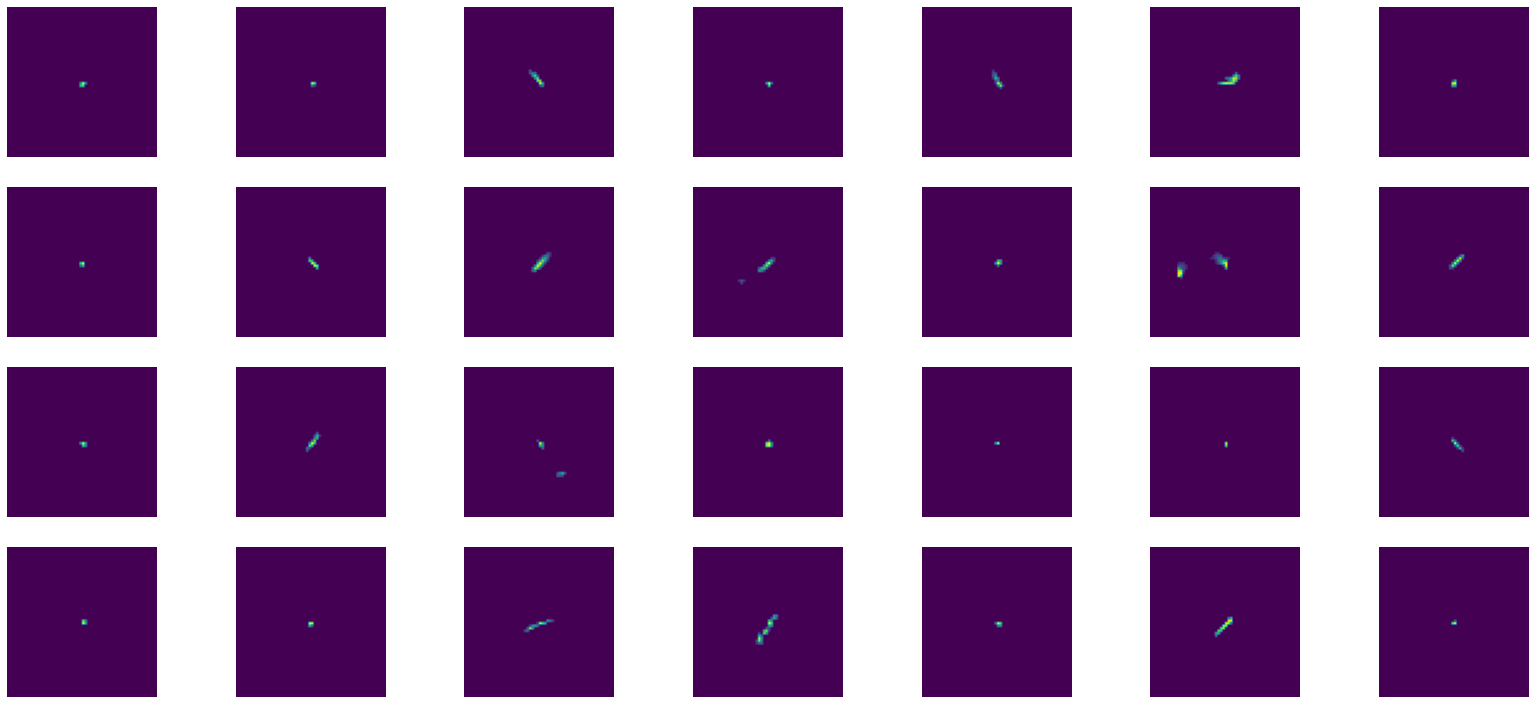

All files: 13824
wybrane_final\17209259.png
wybrane_final\1399336.png
wybrane_final\11818158.png
wybrane_final\19613235.png
wybrane_final\8251673.png
wybrane_final\21983126.png
wybrane_final\18007669.png
wybrane_final\21978003.png
wybrane_final\24601489.png
wybrane_final\17038704.png
wybrane_final\24289541.png
wybrane_final\13842660.png
wybrane_final\24614015.png
wybrane_final\1650352.png
wybrane_final\24292555.png
wybrane_final\21969375.png
wybrane_final\6891800.png
wybrane_final\24591919.png
wybrane_final\21974254.png
wybrane_final\24592361.png
wybrane_final\17851118.png
wybrane_final\1302838.png
wybrane_final\21979347.png
wybrane_final\23175450.png
wybrane_final\12007949.png
wybrane_final\21983567.png
wybrane_final\1851780.png
wybrane_final\1682528.png


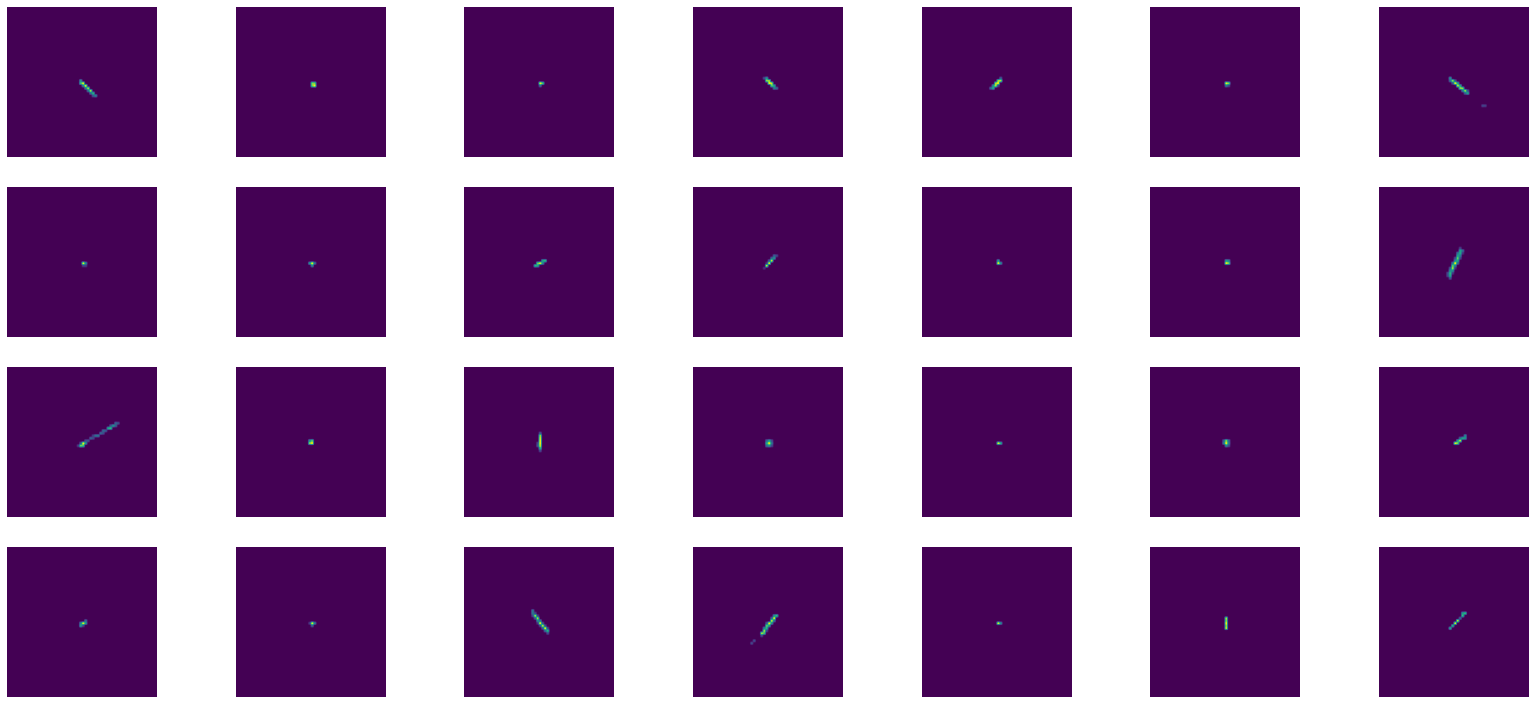

All files: 13824
wybrane_final\22299851.png
wybrane_final\1314736.png
wybrane_final\24626531.png
wybrane_final\1392122.png
wybrane_final\22322867.png
wybrane_final\5013399.png
wybrane_final\11634205.png
wybrane_final\18413969.png
wybrane_final\18002244.png
wybrane_final\15493389.png
wybrane_final\11896733.png
wybrane_final\8233626.png
wybrane_final\21978948.png
wybrane_final\11602203.png
wybrane_final\1352023.png
wybrane_final\1305490.png
wybrane_final\12279213.png
wybrane_final\22175437.png
wybrane_final\7491091.png
wybrane_final\19632850.png
wybrane_final\24604540.png
wybrane_final\24604693.png
wybrane_final\2496910.png
wybrane_final\12494497.png
wybrane_final\11895766.png
wybrane_final\22536074.png
wybrane_final\13873474.png
wybrane_final\21979348.png


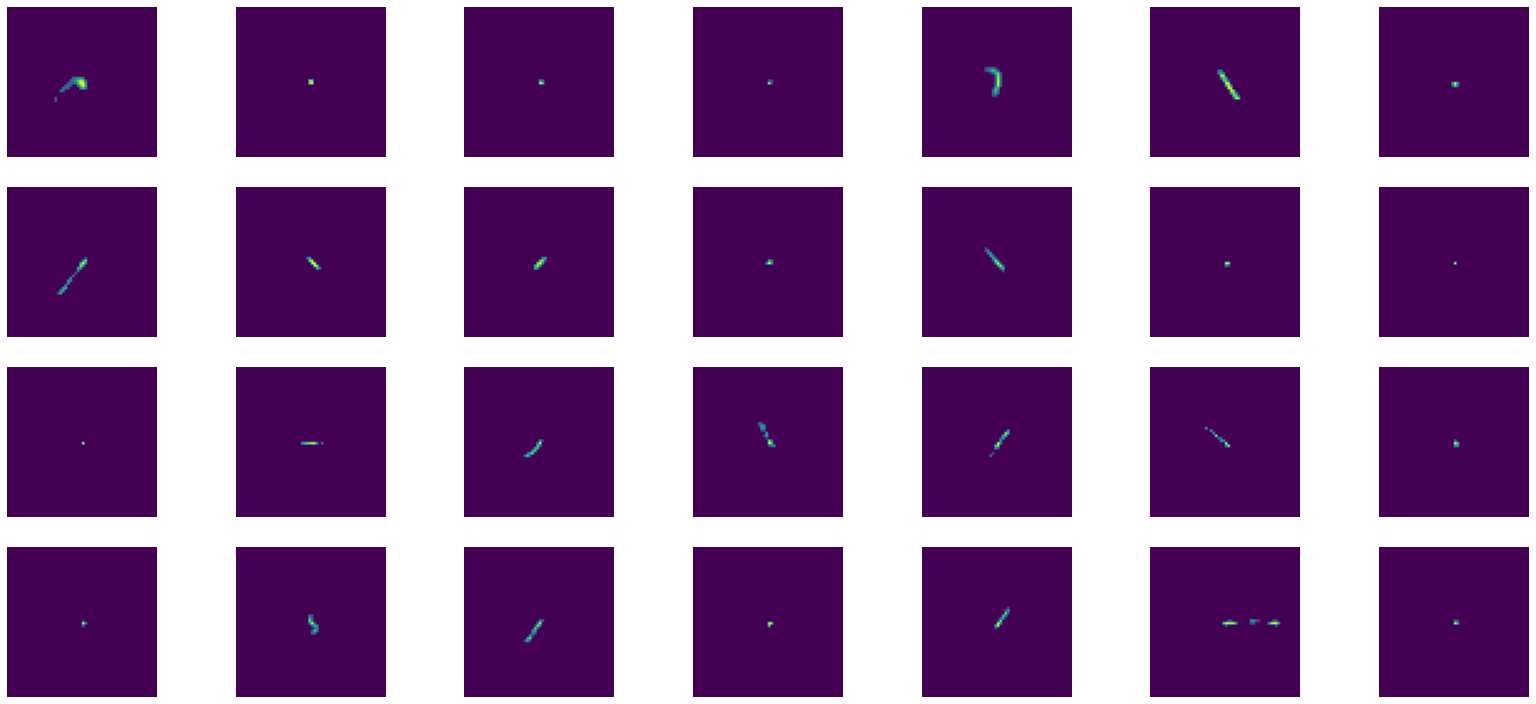

All files: 13824
wybrane_final\11602150.png
wybrane_final\11650471.png
wybrane_final\24615887.png
wybrane_final\21978899.png
wybrane_final\11896057.png
wybrane_final\24188483.png
wybrane_final\11897187.png
wybrane_final\1316327.png
wybrane_final\18698644.png
wybrane_final\10850443.png
wybrane_final\24601581.png
wybrane_final\11634237.png
wybrane_final\23772749.png
wybrane_final\23413690.png
wybrane_final\22174470.png
wybrane_final\22178410.png
wybrane_final\24592584.png
wybrane_final\13672327.png
wybrane_final\22111155.png
wybrane_final\24597263.png
wybrane_final\17357341.png
wybrane_final\11811998.png
wybrane_final\5206435.png
wybrane_final\1312620.png
wybrane_final\21974651.png
wybrane_final\18650916.png
wybrane_final\24595328.png
wybrane_final\24593258.png


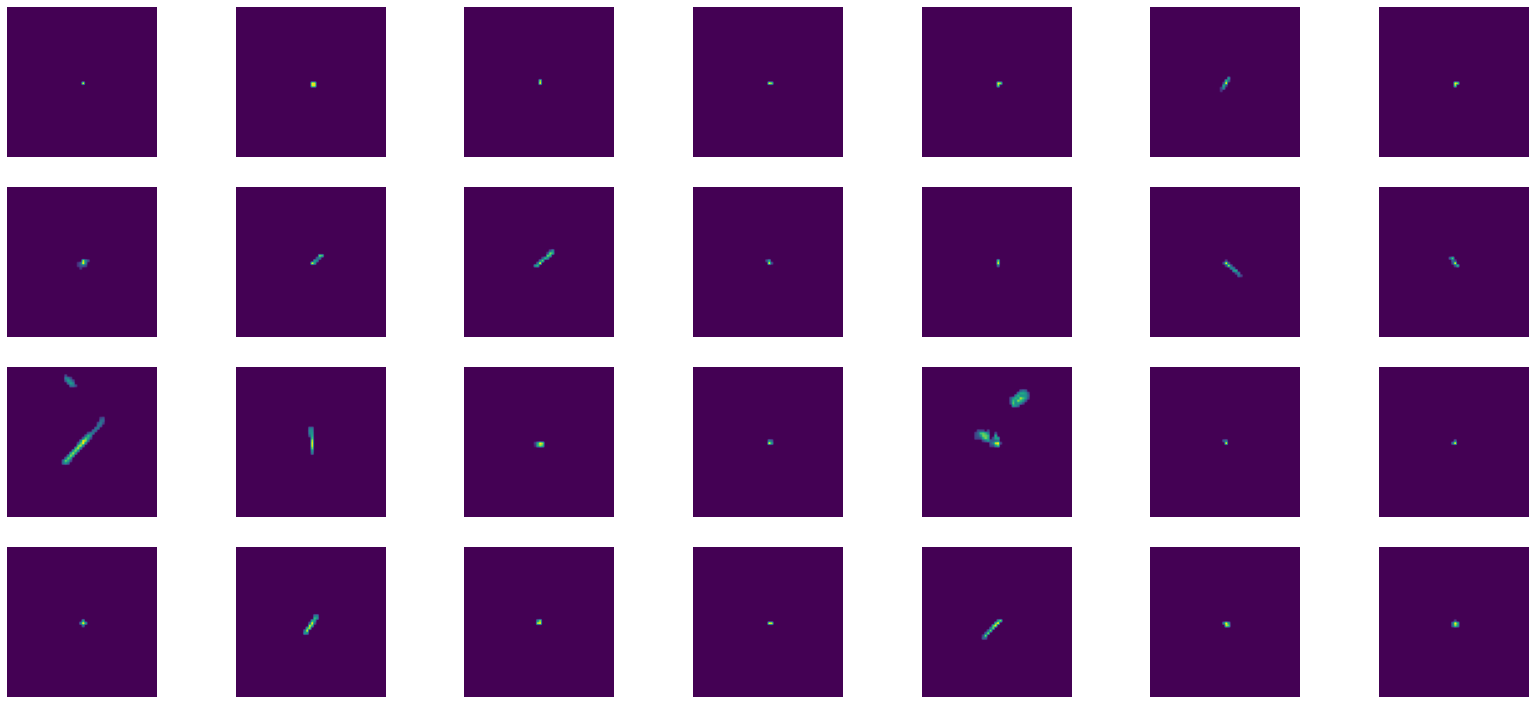

All files: 13824
wybrane_final\13845100.png
wybrane_final\6691422.png
wybrane_final\24605892.png
wybrane_final\21206545.png
wybrane_final\13823465.png
wybrane_final\21726362.png
wybrane_final\11884114.png
wybrane_final\24589755.png
wybrane_final\16034973.png
wybrane_final\1337128.png
wybrane_final\17338073.png
wybrane_final\1650226.png
wybrane_final\6054297.png
wybrane_final\22347357.png
wybrane_final\23050538.png
wybrane_final\15084666.png
wybrane_final\22006772.png
wybrane_final\1746196.png
wybrane_final\24626817.png
wybrane_final\21973961.png
wybrane_final\9869522.png
wybrane_final\11838831.png
wybrane_final\13838816.png
wybrane_final\15669398.png
wybrane_final\1316646.png
wybrane_final\1682601.png
wybrane_final\1308725.png
wybrane_final\24597359.png


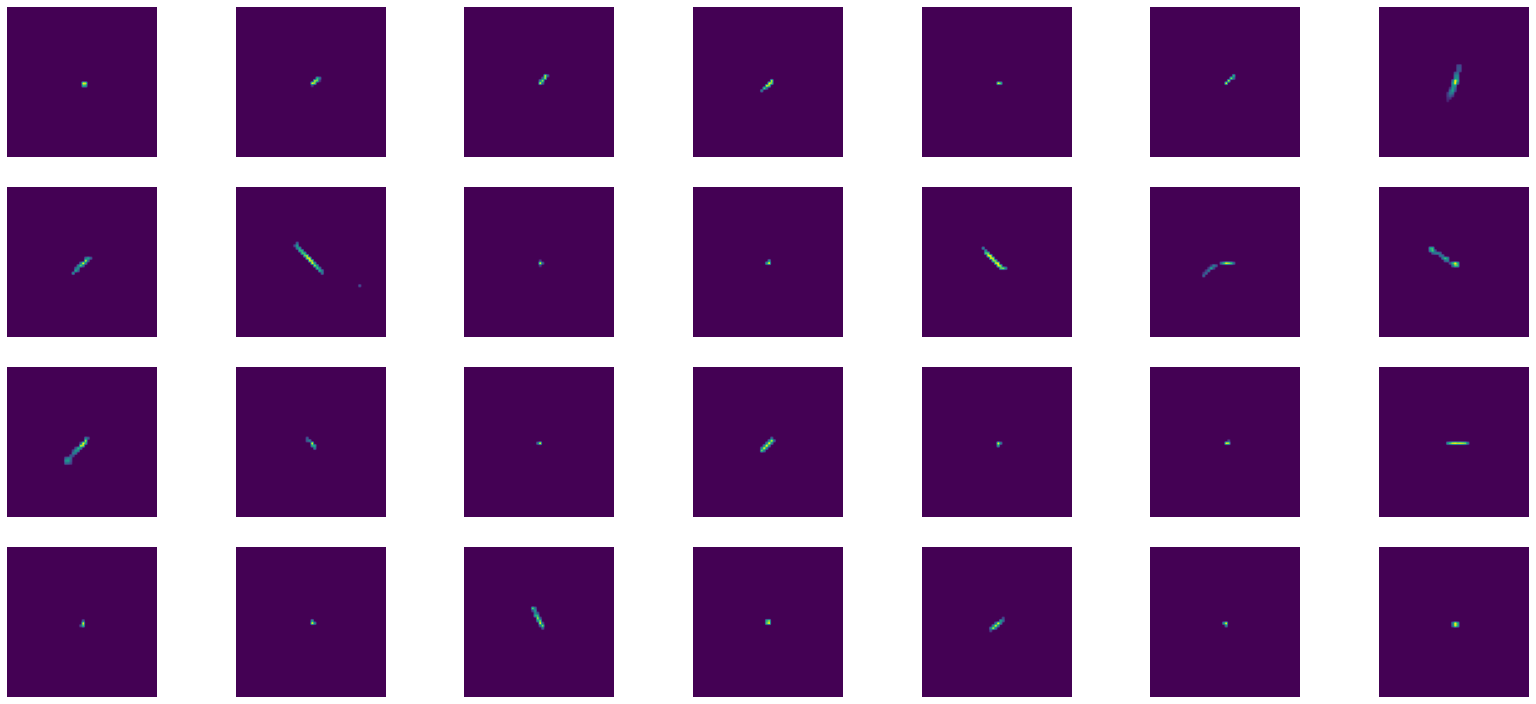

All files: 13824
wybrane_final\13689338.png
wybrane_final\21979304.png
wybrane_final\1350439.png
wybrane_final\11896762.png
wybrane_final\11858430.png
wybrane_final\24617440.png
wybrane_final\11900015.png
wybrane_final\22170259.png
wybrane_final\21876563.png
wybrane_final\13874961.png
wybrane_final\13621271.png
wybrane_final\9219137.png
wybrane_final\10060793.png
wybrane_final\23718074.png
wybrane_final\11444195.png
wybrane_final\7003220.png
wybrane_final\22036077.png
wybrane_final\17645493.png
wybrane_final\24604460.png
wybrane_final\9237713.png
wybrane_final\1304569.png
wybrane_final\17359503.png
wybrane_final\13804507.png
wybrane_final\11649210.png
wybrane_final\13822253.png
wybrane_final\24602443.png
wybrane_final\23601260.png
wybrane_final\10854750.png


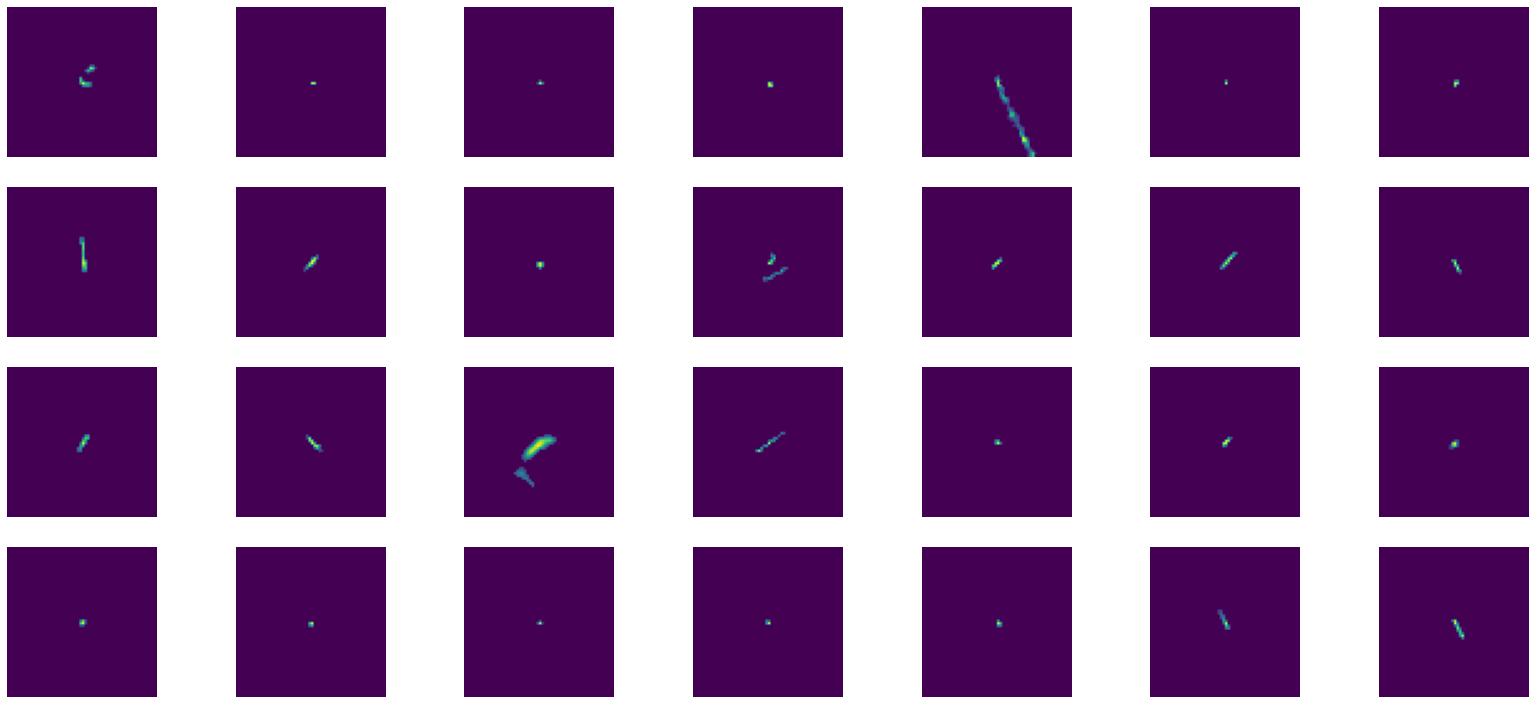

All files: 13824
wybrane_final\21969060.png
wybrane_final\11895752.png
wybrane_final\13619474.png
wybrane_final\22353963.png
wybrane_final\23481083.png
wybrane_final\1746749.png
wybrane_final\13690567.png
wybrane_final\23192042.png
wybrane_final\15665705.png
wybrane_final\12007609.png
wybrane_final\15658253.png
wybrane_final\22038945.png
wybrane_final\24591556.png
wybrane_final\9859129.png
wybrane_final\21979412.png
wybrane_final\15453395.png
wybrane_final\24290190.png
wybrane_final\11829802.png
wybrane_final\1351201.png
wybrane_final\23759566.png
wybrane_final\11897165.png
wybrane_final\22179711.png
wybrane_final\13606491.png
wybrane_final\7473264.png
wybrane_final\21974574.png
wybrane_final\1257491.png
wybrane_final\23635339.png
wybrane_final\11604071.png


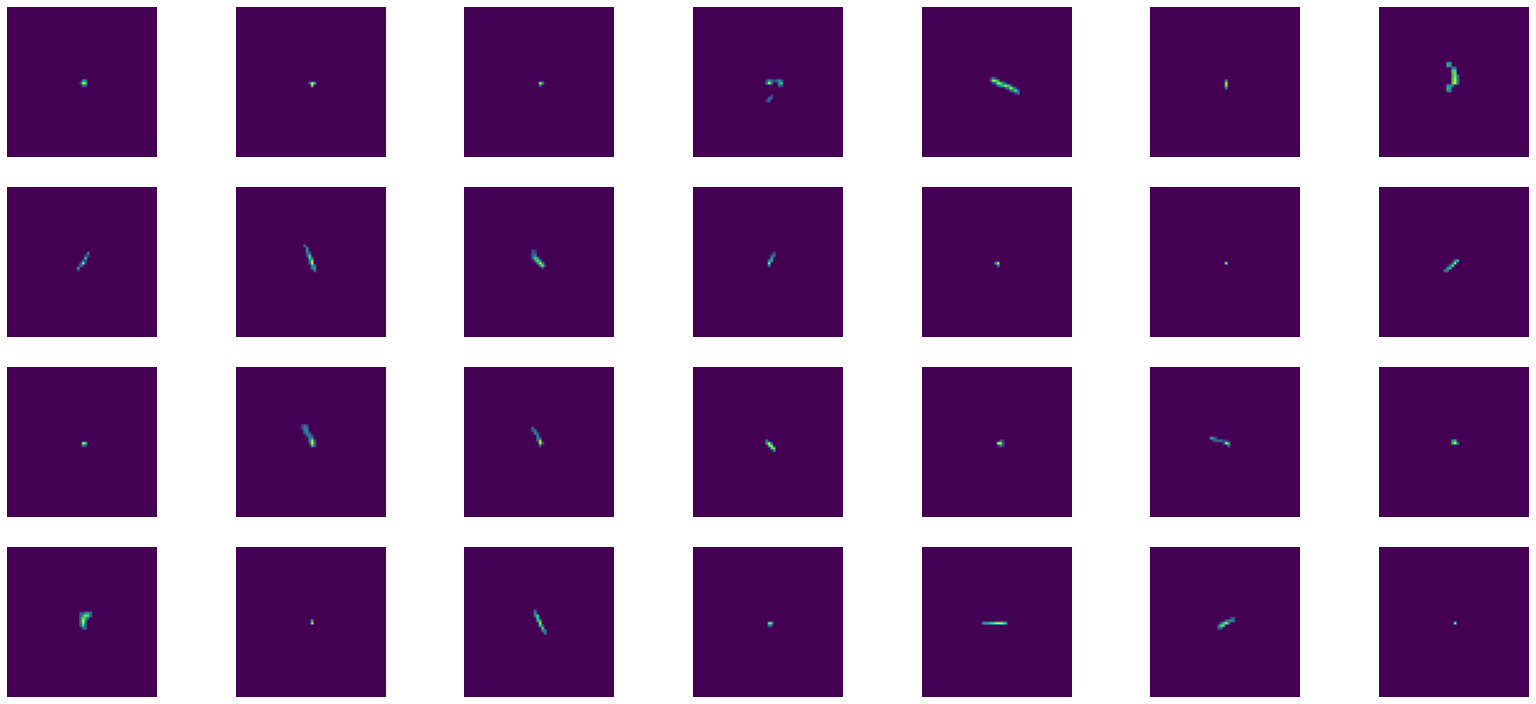

All files: 13824
wybrane_final\1371925.png
wybrane_final\13839713.png
wybrane_final\11634727.png
wybrane_final\11680727.png
wybrane_final\1383625.png
wybrane_final\1340316.png
wybrane_final\24595175.png
wybrane_final\24598016.png
wybrane_final\9065336.png
wybrane_final\24619695.png
wybrane_final\15013223.png
wybrane_final\22444057.png
wybrane_final\10075324.png
wybrane_final\24596619.png
wybrane_final\1358466.png
wybrane_final\11857508.png
wybrane_final\24520313.png
wybrane_final\1364826.png
wybrane_final\21972135.png
wybrane_final\7278284.png
wybrane_final\1383364.png
wybrane_final\7150537.png
wybrane_final\5610628.png
wybrane_final\1380421.png
wybrane_final\1559869.png
wybrane_final\24592822.png
wybrane_final\13610267.png
wybrane_final\13827675.png


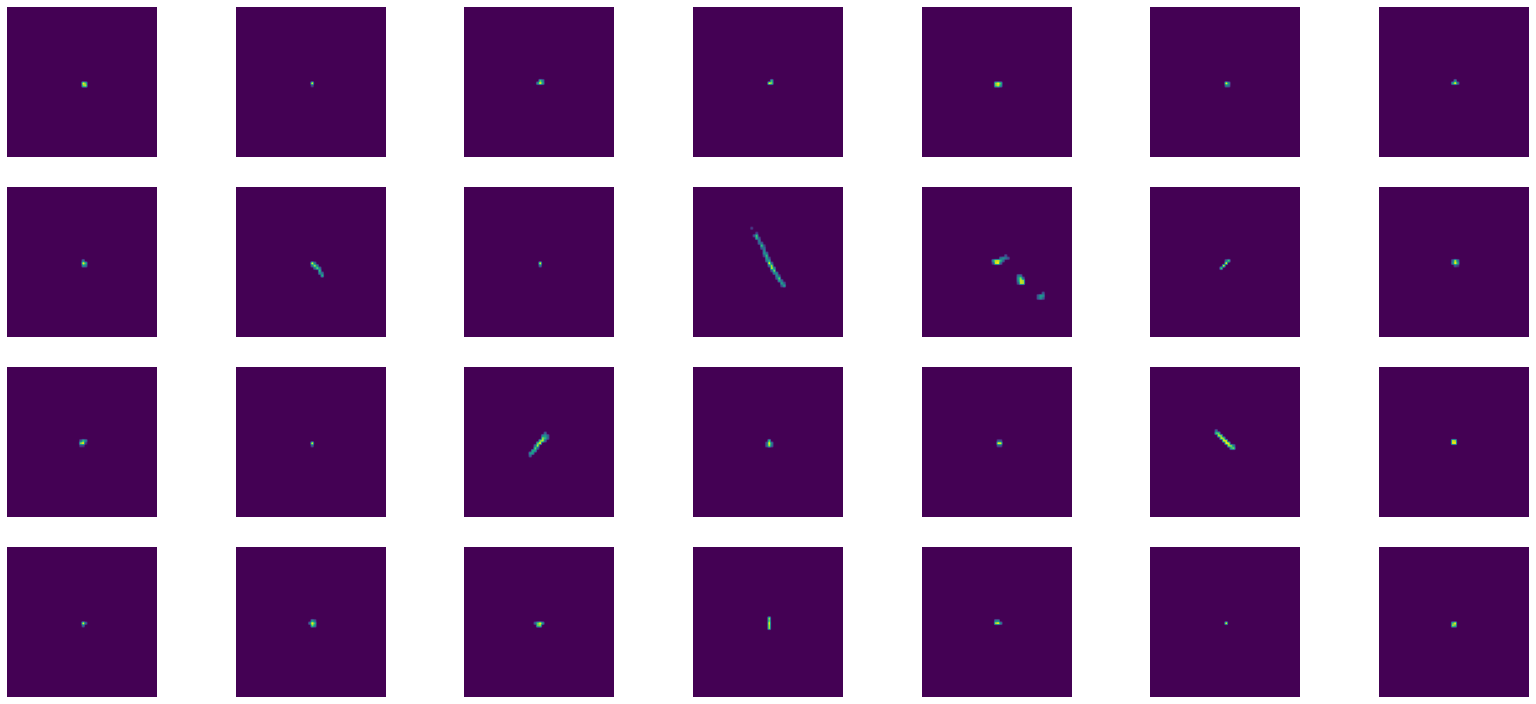

All files: 13824
wybrane_final\17335698.png
wybrane_final\18410209.png
wybrane_final\1311225.png
wybrane_final\11839577.png
wybrane_final\18634997.png
wybrane_final\22911647.png
wybrane_final\11808872.png
wybrane_final\10220540.png
wybrane_final\1305887.png
wybrane_final\2296161.png
wybrane_final\22928322.png
wybrane_final\15434189.png
wybrane_final\11896072.png
wybrane_final\24175400.png
wybrane_final\17214565.png
wybrane_final\24601140.png
wybrane_final\21972298.png
wybrane_final\17066484.png
wybrane_final\1368600.png
wybrane_final\24601337.png
wybrane_final\24593895.png
wybrane_final\13822354.png
wybrane_final\11898590.png
wybrane_final\1338280.png
wybrane_final\11866801.png
wybrane_final\24601816.png
wybrane_final\11872085.png
wybrane_final\1357509.png


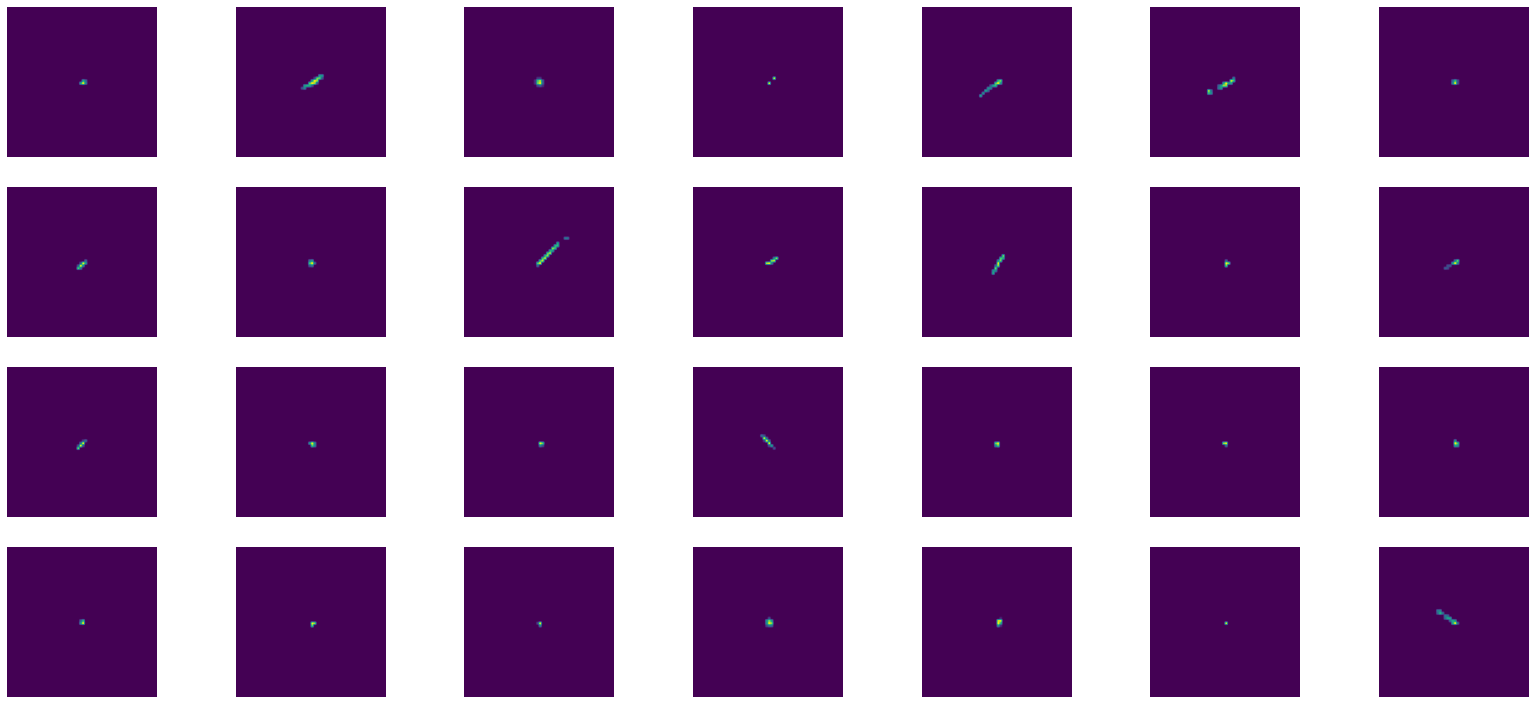

All files: 13824
wybrane_final\23764519.png
wybrane_final\21974736.png
wybrane_final\23155733.png
wybrane_final\15694252.png
wybrane_final\13842150.png
wybrane_final\24594067.png
wybrane_final\18460759.png
wybrane_final\1369216.png
wybrane_final\8641072.png
wybrane_final\11872112.png
wybrane_final\6692216.png
wybrane_final\11817563.png
wybrane_final\9285059.png
wybrane_final\22400006.png
wybrane_final\10215711.png
wybrane_final\24591991.png
wybrane_final\24604397.png
wybrane_final\1357969.png
wybrane_final\11634170.png
wybrane_final\24167656.png
wybrane_final\22220899.png
wybrane_final\9683095.png
wybrane_final\21970642.png
wybrane_final\23227699.png
wybrane_final\9422369.png
wybrane_final\21978498.png
wybrane_final\17358863.png
wybrane_final\16880556.png


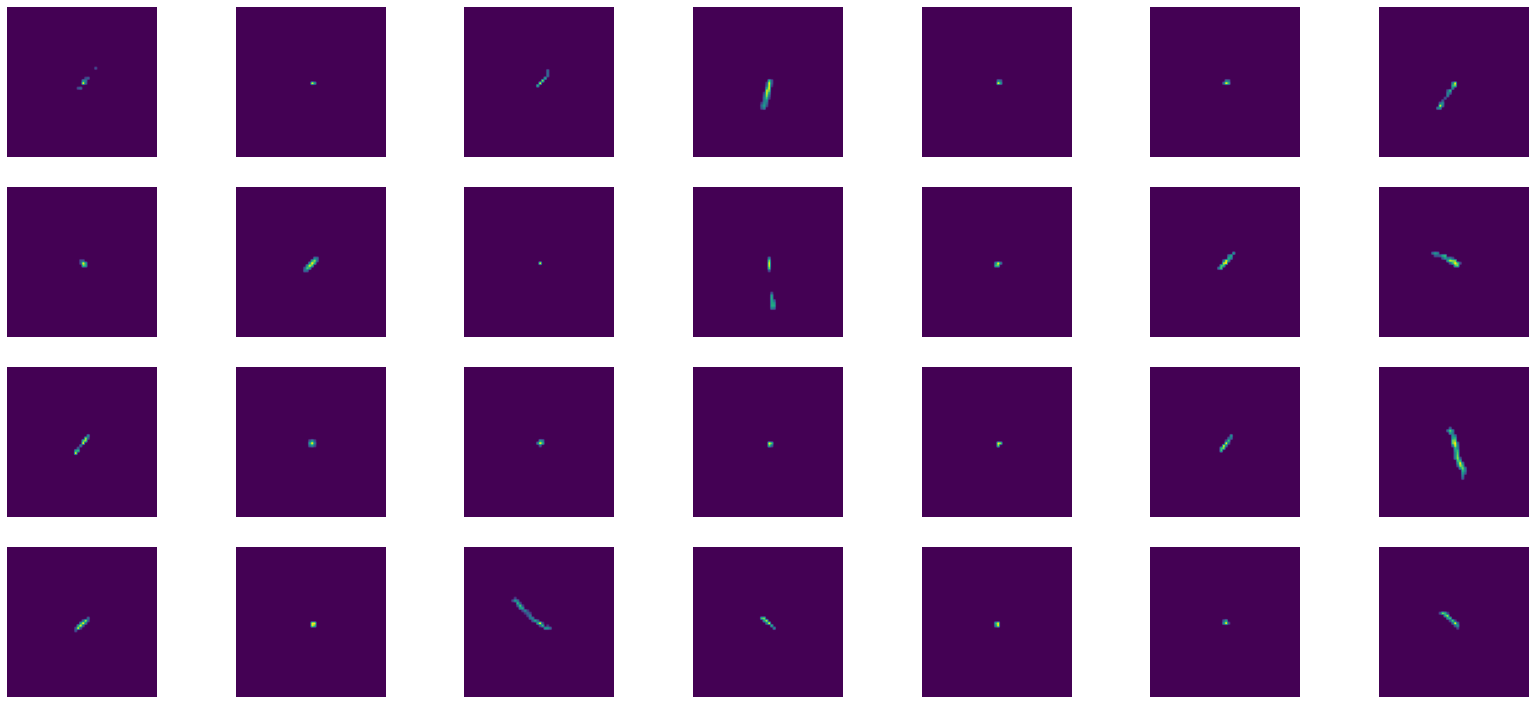

All files: 13824
wybrane_final\21282964.png
wybrane_final\23941397.png
wybrane_final\21974957.png
wybrane_final\18279294.png
wybrane_final\18413969.png
wybrane_final\13827899.png
wybrane_final\11800417.png
wybrane_final\21969895.png
wybrane_final\13842884.png
wybrane_final\17476104.png
wybrane_final\21974643.png
wybrane_final\22354765.png
wybrane_final\23163961.png
wybrane_final\24596667.png
wybrane_final\23277730.png
wybrane_final\24592592.png
wybrane_final\24598104.png
wybrane_final\11057270.png
wybrane_final\10051968.png
wybrane_final\22442437.png
wybrane_final\9237713.png
wybrane_final\21972517.png
wybrane_final\21979320.png
wybrane_final\17467174.png
wybrane_final\24601489.png
wybrane_final\23294180.png
wybrane_final\24593876.png
wybrane_final\21066525.png


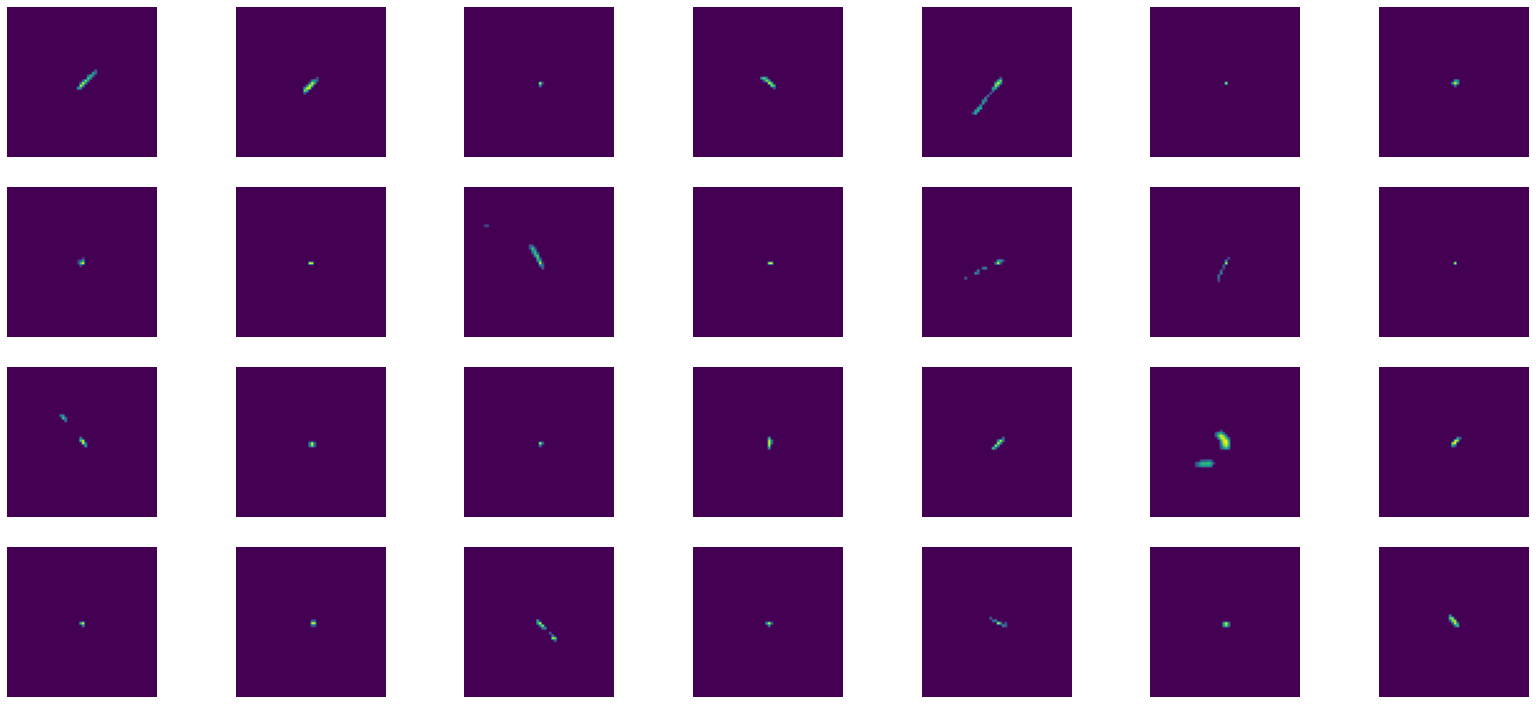

All files: 13824
wybrane_final\9594677.png
wybrane_final\23123109.png
wybrane_final\15627202.png
wybrane_final\1312620.png
wybrane_final\21979051.png
wybrane_final\13071608.png
wybrane_final\1823887.png
wybrane_final\10620024.png
wybrane_final\22009512.png
wybrane_final\11861391.png
wybrane_final\1292175.png
wybrane_final\21068319.png
wybrane_final\24596313.png
wybrane_final\10096597.png
wybrane_final\7036895.png
wybrane_final\22209629.png
wybrane_final\24595198.png
wybrane_final\24581325.png
wybrane_final\11897353.png
wybrane_final\1309050.png
wybrane_final\24604459.png
wybrane_final\5292339.png
wybrane_final\13071716.png
wybrane_final\21979057.png
wybrane_final\24326910.png
wybrane_final\18266093.png
wybrane_final\21974572.png
wybrane_final\23123109.png


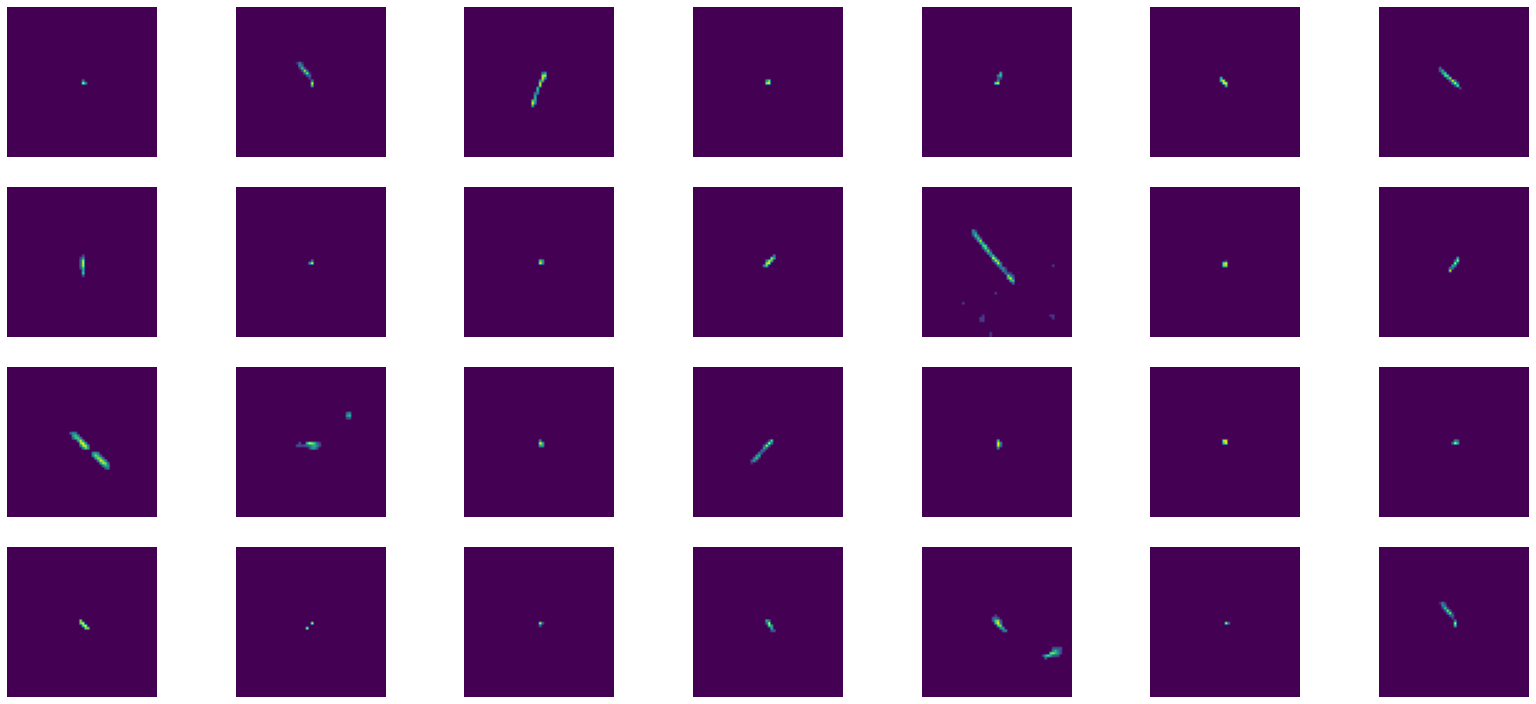

All files: 13824
wybrane_final\19433454.png
wybrane_final\16680308.png
wybrane_final\18081761.png
wybrane_final\11408288.png
wybrane_final\1370587.png
wybrane_final\1304642.png
wybrane_final\23285517.png
wybrane_final\24097361.png
wybrane_final\21974808.png
wybrane_final\16610088.png
wybrane_final\17676613.png
wybrane_final\13685016.png
wybrane_final\24603445.png
wybrane_final\22307422.png
wybrane_final\15049688.png
wybrane_final\21983805.png
wybrane_final\11808502.png
wybrane_final\23147587.png
wybrane_final\7281121.png
wybrane_final\15209696.png
wybrane_final\22006608.png
wybrane_final\24590098.png
wybrane_final\11439815.png
wybrane_final\11613348.png
wybrane_final\22763871.png
wybrane_final\13624551.png
wybrane_final\24601928.png
wybrane_final\4475797.png


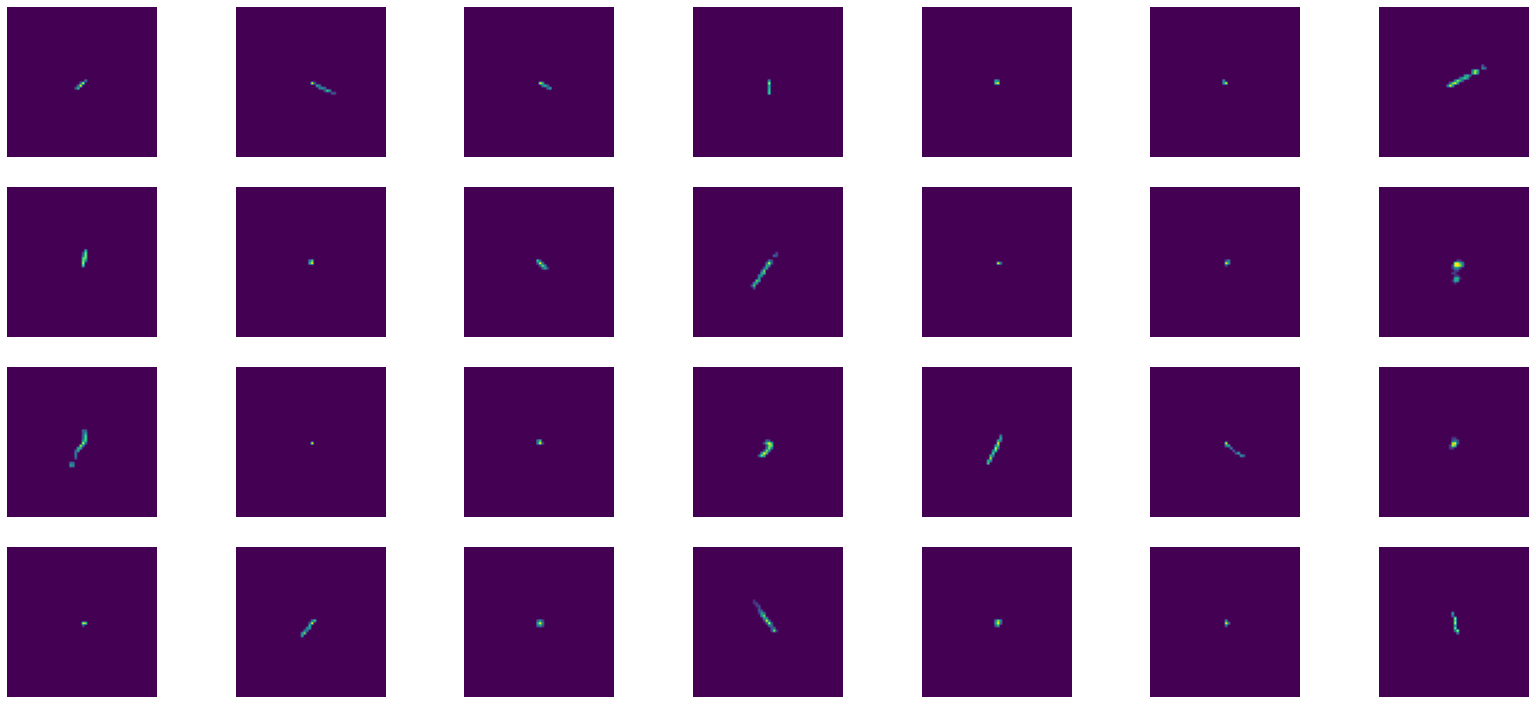

All files: 13824
wybrane_final\22358787.png
wybrane_final\1350393.png
wybrane_final\23184676.png
wybrane_final\11861409.png
wybrane_final\24320731.png
wybrane_final\24613484.png
wybrane_final\23171216.png
wybrane_final\23477841.png
wybrane_final\24192768.png
wybrane_final\11833970.png
wybrane_final\1369305.png
wybrane_final\11823533.png
wybrane_final\24627717.png
wybrane_final\11866874.png
wybrane_final\18287527.png
wybrane_final\24591188.png
wybrane_final\11813759.png
wybrane_final\1315860.png
wybrane_final\24622818.png
wybrane_final\11058129.png
wybrane_final\11861436.png
wybrane_final\14618979.png
wybrane_final\11699033.png
wybrane_final\23113667.png
wybrane_final\23185374.png
wybrane_final\1381693.png
wybrane_final\11833850.png
wybrane_final\21981636.png


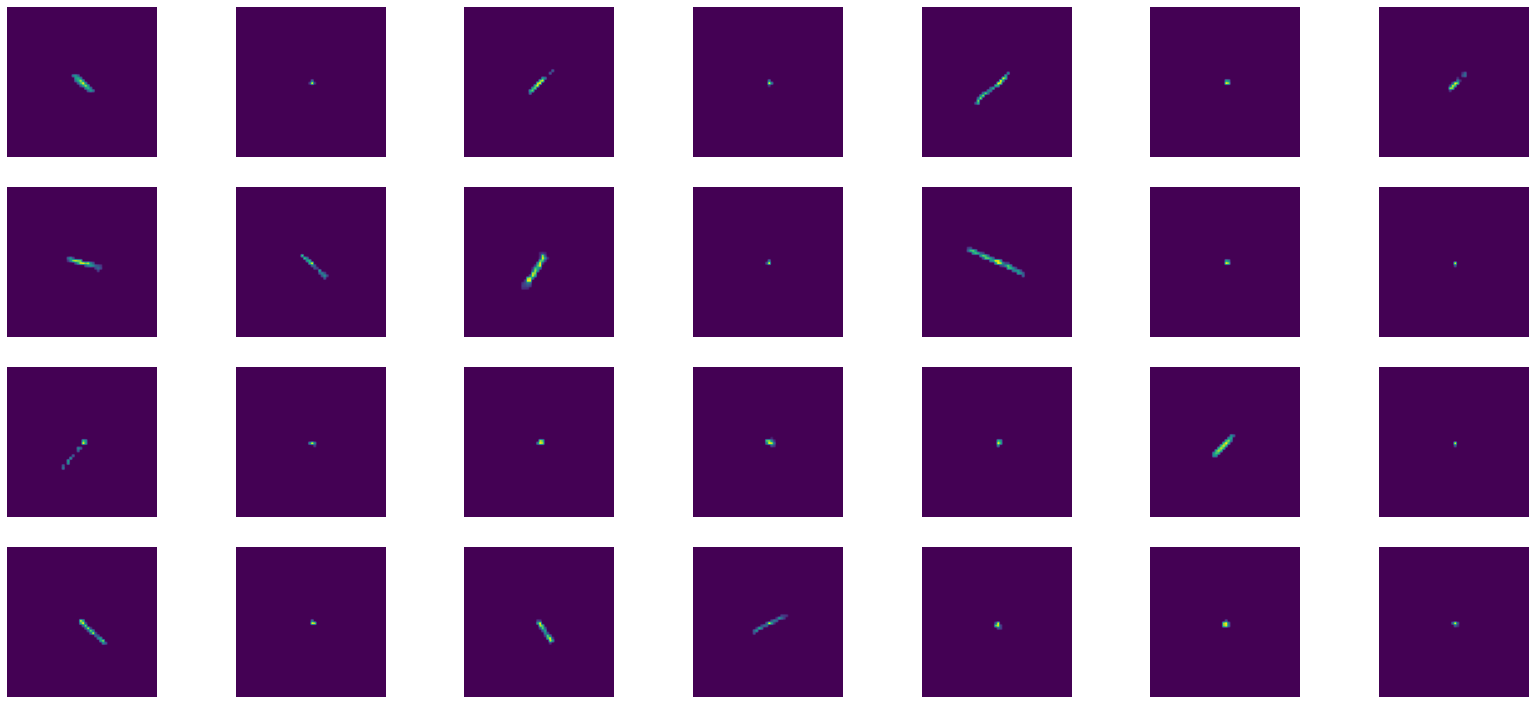

All files: 13824
wybrane_final\19489253.png
wybrane_final\24322888.png
wybrane_final\4435242.png
wybrane_final\24594194.png
wybrane_final\13658701.png
wybrane_final\1383010.png
wybrane_final\10424866.png
wybrane_final\23427043.png
wybrane_final\1352811.png
wybrane_final\15683882.png
wybrane_final\22344431.png
wybrane_final\18270500.png
wybrane_final\11899901.png
wybrane_final\10837737.png
wybrane_final\11883066.png
wybrane_final\24457495.png
wybrane_final\1349770.png
wybrane_final\24628687.png
wybrane_final\11837895.png
wybrane_final\1620563.png
wybrane_final\24604419.png
wybrane_final\14495007.png
wybrane_final\1356101.png
wybrane_final\24615708.png
wybrane_final\21974957.png
wybrane_final\11699716.png
wybrane_final\24270112.png
wybrane_final\21973567.png


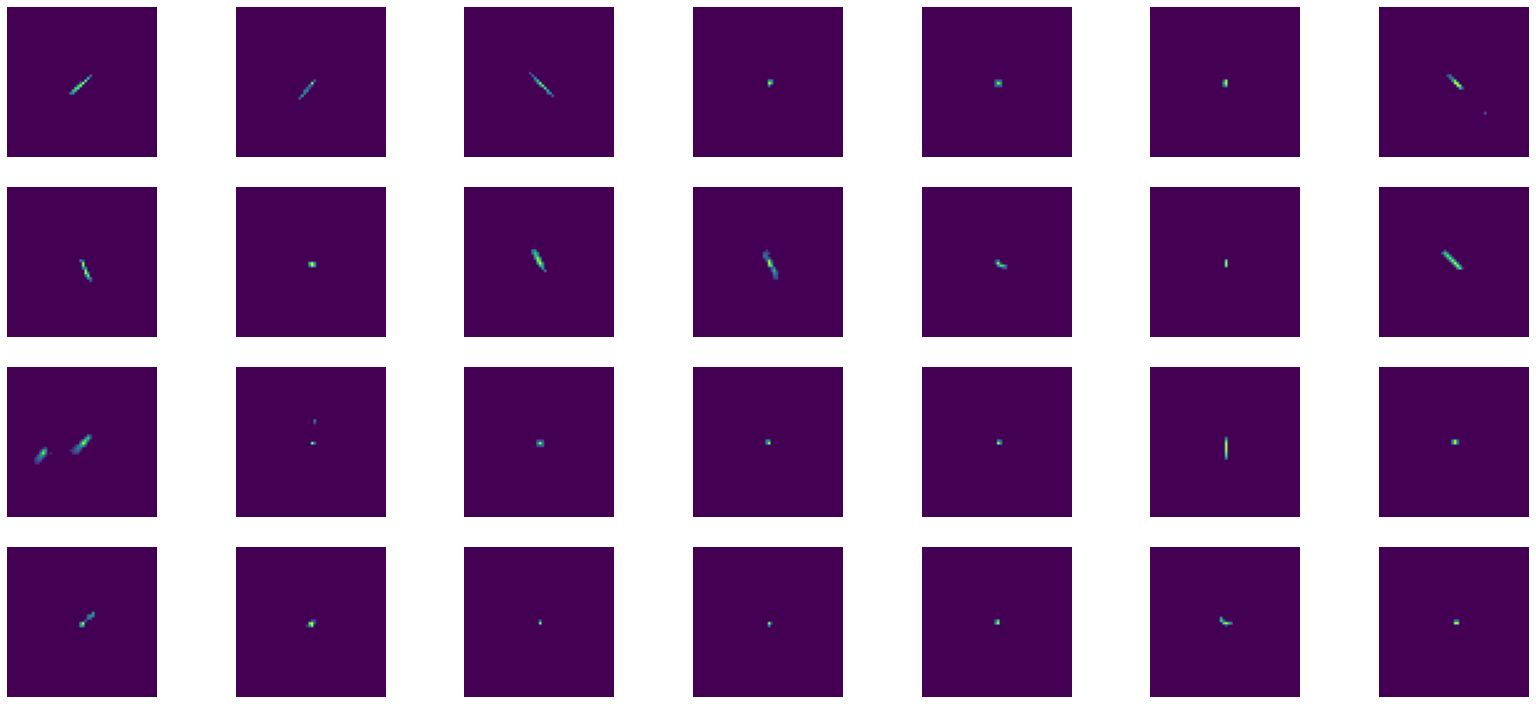

All files: 13824
wybrane_final\23741777.png
wybrane_final\24594252.png
wybrane_final\1350554.png
wybrane_final\21977336.png
wybrane_final\17355289.png
wybrane_final\20423137.png
wybrane_final\24602330.png
wybrane_final\1380917.png
wybrane_final\23221313.png
wybrane_final\11837826.png
wybrane_final\22453934.png
wybrane_final\22212427.png
wybrane_final\23844291.png
wybrane_final\4205672.png
wybrane_final\11897350.png
wybrane_final\19489253.png
wybrane_final\23834398.png
wybrane_final\24594624.png
wybrane_final\21978827.png
wybrane_final\22019721.png
wybrane_final\24624220.png
wybrane_final\24601986.png
wybrane_final\11861409.png
wybrane_final\11898872.png
wybrane_final\1354923.png
wybrane_final\11839725.png
wybrane_final\22012645.png
wybrane_final\22299848.png


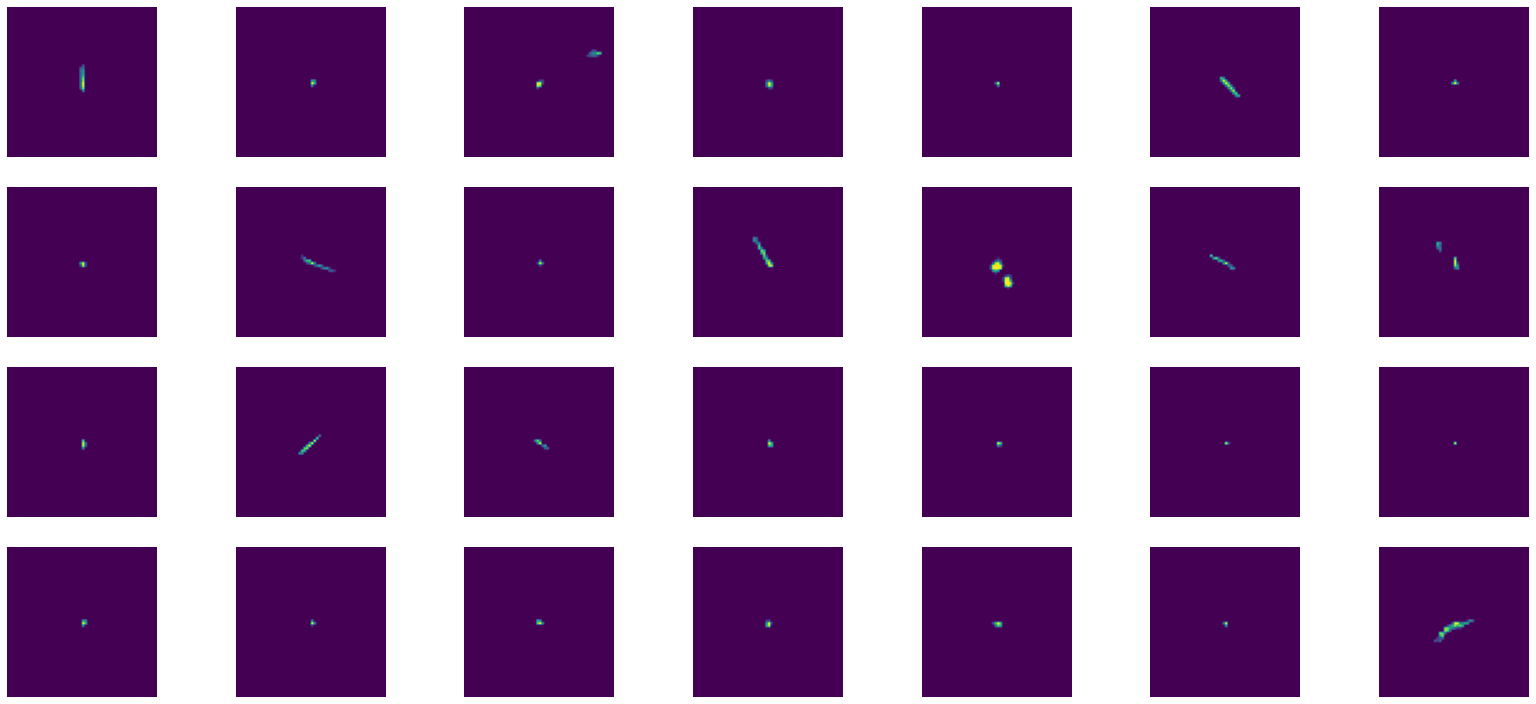

In [10]:
from random import randrange
import matplotlib.pyplot as plt

for i in range(20):
    fig = plt.figure(figsize=(28, 16))
    columns = 7
    rows = int(28 / 7) + 1

    print('All files: %d' % len(all_files))

    for aaa in range(28):
        index = randrange(len(all_files))
        img_help = load_image(all_files[index], False)
        print(all_files[index])

        aaa1 = aaa + 1
        r = fig.add_subplot(rows, columns, aaa1)
        r.axis("off")
        plt.imshow(img_help)

    plt.show()